In [1]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/gonzalo/Downloads/ml4cc-general-access_request_pays.json"
os.environ["GS_USER_PROJECT"] = "ml4cc-general"

In [2]:
from ml4floods.data import utils
from ml4floods.visualization import plot_utils

path_to_aois = "gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/"
fs = utils.get_filesystem(path_to_aois)

[Flooding period according to Wikipedia](https://en.wikipedia.org/wiki/2022_Eastern_Australia_floods): 23 February 2022 – 7 April 2022

We divide this period in:
* Flooding period first flood 23rd Feb to 27th March
* Flooding period second flood 28th March 10th April


In [3]:
flooding_date_pre = "2022-02-20"
flooding_date_first_period_start= "2022-02-23"
flooding_date_first_period_end = "2022-03-27"

flooding_date_second_period_start = "2022-03-28"
flooding_date_second_period_end = "2022-04-10"

## Step 1: Grab all the predicted floodmaps for a given Area of Interest

In [4]:
# Grab all predictions for a given AOI

# i = "AOI02" # Lismore AoI

aoi = "QLAOI03" # Cabolture AoI (images out of swath, clouds etc)

geojsons = [f"gs://{f}" for f in fs.glob(f"{path_to_aois}{aoi}/WF2_unet_rbgiswirs_vec/*/*.geojson")]
# Sort by date (name of the file)
geojsons.sort(key=lambda x: os.path.splitext(os.path.basename(x))[0])
geojsons

['gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/Landsat/2022-02-07.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-02-08.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-02-18.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/Landsat/2022-03-19.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-03-30.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-03-31.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/Landsat/2022-04-04.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-04-05.geojson']

## Plot mean cloud coverage of available S2 and Landsat images

We have downloaded all images which have less than 60% of clouds

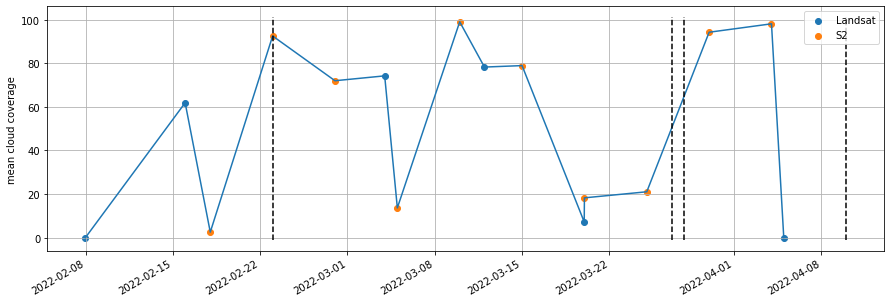

In [5]:
from ml4floods.data.ee_download import process_metadata
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

metadata_s2 = process_metadata(f"{path_to_aois}{aoi}/S2/s2info.csv")
metadata_l89 = process_metadata(f"{path_to_aois}{aoi}/Landsat/landsatinfo.csv")

metadata_s2["satellite"] = "S2"
metadata_l89["satellite"] = "Landsat"
metadata = pd.concat([metadata_s2, metadata_l89],ignore_index=True)
metadata.cloud_probability*=100
metadata = metadata[metadata["valids"] >= .8]
fig, ax = plt.subplots(1,1,figsize=(15,5))

flood_date_1 = "2022-02-26"
for c in ["Landsat","S2"]:
    ax.scatter(x=metadata[metadata.satellite == c].datetime,y=metadata[metadata.satellite == c].cloud_probability, label=c)

ax.legend()
metadata.plot(x="datetime",y="cloud_probability",ax=ax,legend=None)
for d in [flooding_date_first_period_start, flooding_date_first_period_end,flooding_date_second_period_start,flooding_date_second_period_end]:
    plt.vlines(x=datetime.strptime(d,"%Y-%m-%d"),ymin=-1,ymax=101,colors="black",linestyles="dashed")
    
plt.ylabel("mean cloud coverage")
plt.xlabel("")
plt.grid()

### Plot processed floodmaps

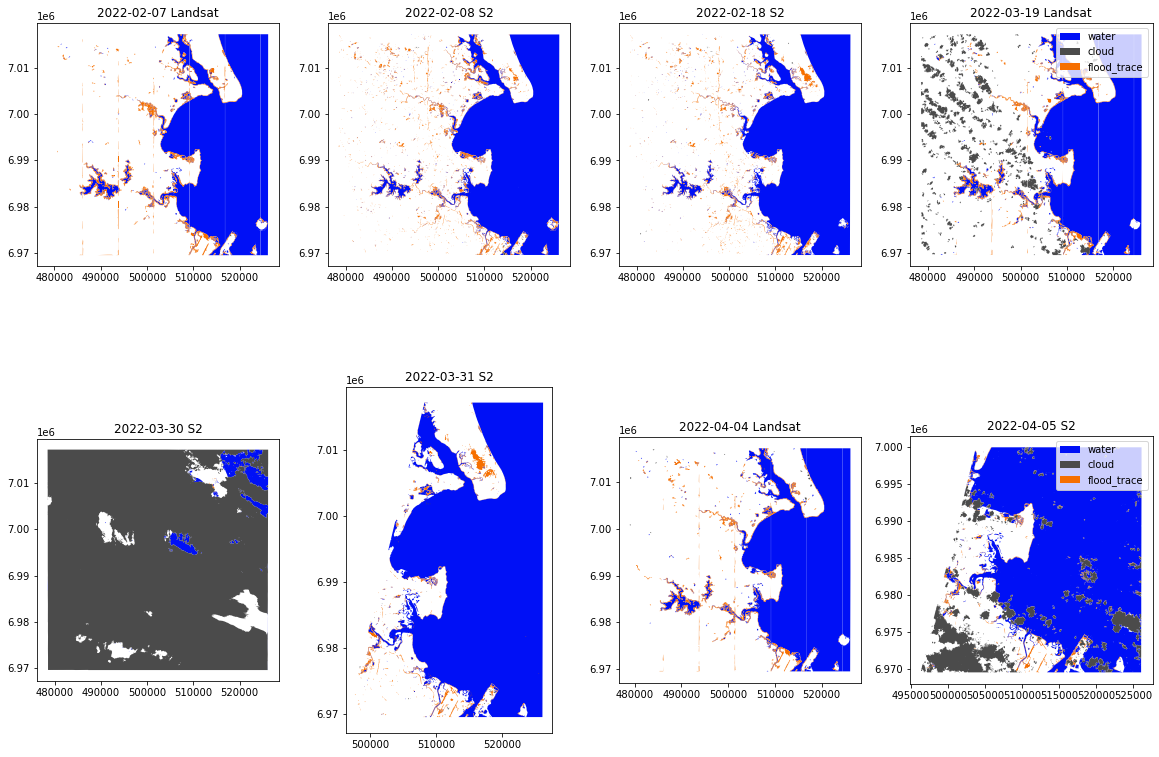

In [6]:
import matplotlib.pyplot as plt
from math import ceil

fig, ax =plt.subplots(ceil(len(geojsons)/ 4),4,figsize=(20,14))
ax = ax.flatten()

for idx,g in enumerate(geojsons):
    date = os.path.splitext(os.path.basename(g))[0]
    satellite = os.path.basename(os.path.dirname(g))
    floodmap = utils.read_geojson_from_gcp(g)
    plot_utils.plot_floodmap(floodmap, ax=ax[idx],legend=(idx%4)==3)
    ax[idx].set_title(f"{date} {satellite}")

## Step 2: Get the water content before the flooding

In [7]:
from ml4floods.models import postprocess

floodmaps_pre = [g for g in geojsons if os.path.splitext(os.path.basename(g))[0] < flooding_date_pre]
print(f"Floodmaps to process before the flooding: {floodmaps_pre}")
data_pre = postprocess.get_floodmap_pre(floodmaps_pre,verbose=True)
data_pre

Floodmaps to process before the flooding: ['gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/Landsat/2022-02-07.geojson', 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-02-08.geojson', 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-02-18.geojson']


,class,geometry
0,water,"POLYGON ((495480.000 6979530.000, 495510.000 6..."
1,water,"POLYGON ((485790.000 6982470.000, 485790.000 6..."
2,water,"POLYGON ((498750.000 6983190.000, 498990.000 6..."
4,water,"POLYGON ((498060.000 6983190.000, 498000.000 6..."
5,water,"POLYGON ((498780.000 6983250.000, 498690.000 6..."
...,...,...
166,water,"POLYGON ((518250.000 7009410.000, 518280.000 7..."
167,water,"POLYGON ((526170.000 7017260.000, 526200.000 7..."
168,water,"POLYGON ((516630.000 7013220.000, 516630.000 7..."
169,cloud,"POLYGON ((518100.000 6973800.000, 518100.000 6..."


<AxesSubplot:>

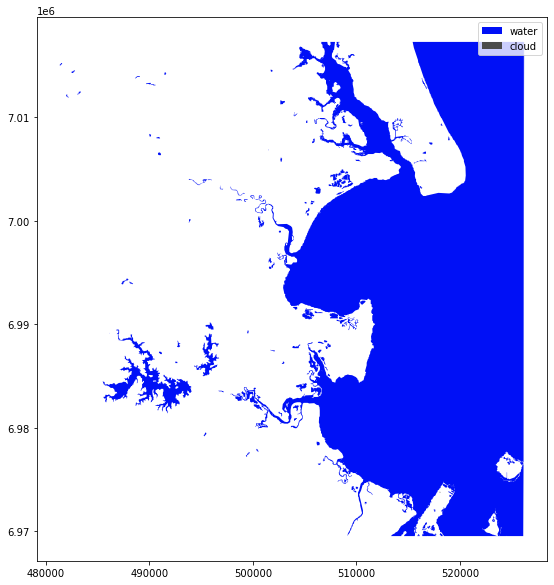

In [8]:
plot_utils.plot_floodmap(data_pre)

## Step 3: Get the water content after the first flooding event

In [9]:
floodmaps_post_first_list = [g for g in geojsons if (os.path.splitext(os.path.basename(g))[0] >= flooding_date_first_period_start) and (os.path.splitext(os.path.basename(g))[0] < flooding_date_first_period_end)]
floodmaps_post_first_list

['gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/Landsat/2022-03-19.geojson']

In [10]:
%%time

floodmaps_post_first_list = [g for g in geojsons if (os.path.splitext(os.path.basename(g))[0] >= flooding_date_first_period_start) and (os.path.splitext(os.path.basename(g))[0] < flooding_date_first_period_end)]
print(f"Floodmaps to process for the first period: {floodmaps_post_first_list}")
data_post_first_period = postprocess.get_floodmap_post(floodmaps_post_first_list,verbose=True)
data_post_first_period

Floodmaps to process for the first period: ['gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/Landsat/2022-03-19.geojson']
CPU times: user 727 ms, sys: 18.3 ms, total: 745 ms
Wall time: 931 ms


,class,geometry
0,flood_trace,"POLYGON ((489210.000 6969600.000, 490050.000 6..."
1,flood_trace,"POLYGON ((486090.000 6970290.000, 486120.000 6..."
2,flood_trace,"POLYGON ((486150.000 6972660.000, 486180.000 6..."
3,flood_trace,"POLYGON ((486120.000 6971820.000, 486060.000 6..."
4,flood_trace,"POLYGON ((485940.000 6976770.000, 485700.000 6..."
...,...,...
907,area_imaged,"POLYGON ((509190.000 6969540.000, 509190.000 7..."
908,area_imaged,"POLYGON ((516870.000 6969540.000, 516870.000 7..."
909,area_imaged,"POLYGON ((526110.000 6969540.000, 524550.000 6..."
910,area_imaged,"POLYGON ((478530.000 6969570.000, 478470.000 7..."


<AxesSubplot:>

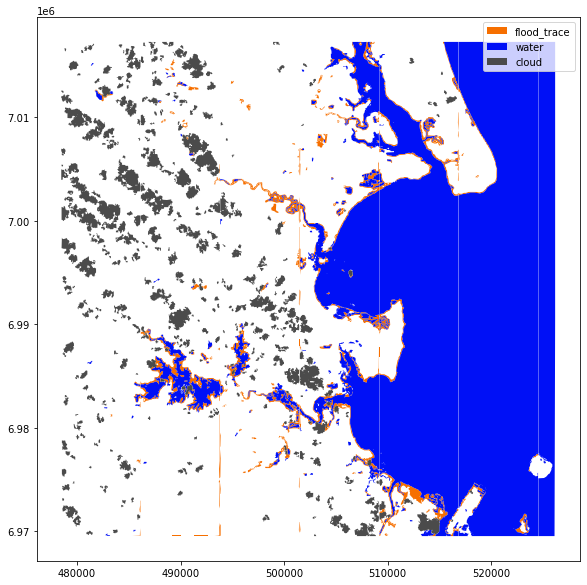

In [11]:
plot_utils.plot_floodmap(data_post_first_period)

### Plot the difference between pre and post flood observed water

In [12]:
prepost_map = postprocess.compute_flood_water(floodmap_post_data=data_post_first_period, best_pre_flood_data=data_pre)
prepost_map

,class,geometry
0,water-pre-flood,"POLYGON ((495480.000 6979530.000, 495510.000 6..."
1,water-pre-flood,"POLYGON ((485790.000 6982470.000, 485790.000 6..."
2,water-pre-flood,"POLYGON ((498750.000 6983190.000, 498990.000 6..."
3,water-pre-flood,"POLYGON ((498060.000 6983190.000, 498000.000 6..."
4,water-pre-flood,"POLYGON ((498780.000 6983250.000, 498690.000 6..."
...,...,...
2849,water-post-flood,"POLYGON ((515610.000 7016490.000, 515587.500 7..."
2850,water-post-flood,"POLYGON ((516840.000 7013010.000, 516690.000 7..."
2851,water-post-flood,"POLYGON ((516570.000 7013520.000, 516540.000 7..."
2852,water-post-flood,"POLYGON ((509490.000 7015770.000, 509400.000 7..."


<AxesSubplot:>

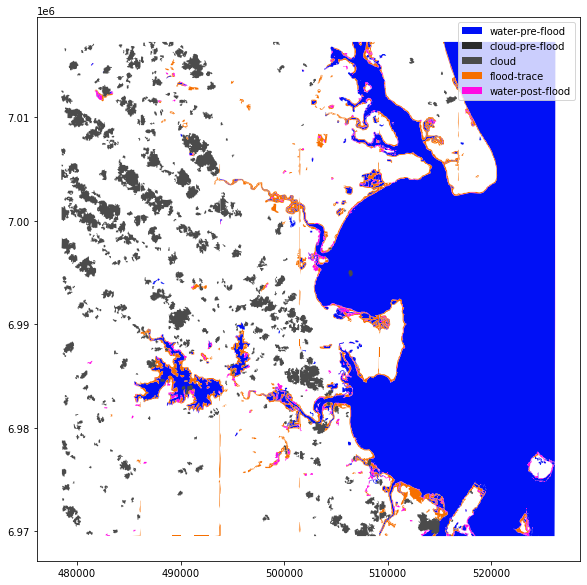

In [13]:
plot_utils.plot_floodmap(prepost_map)

## Step 4: Get the water content after the second flooding event

In [14]:
floodmaps_post_second_list = [g for g in geojsons if (os.path.splitext(os.path.basename(g))[0] >= flooding_date_second_period_start) and (os.path.splitext(os.path.basename(g))[0] < flooding_date_second_period_end)]
print(f"Floodmaps to process for the second period: {floodmaps_post_second_list}")
data_post_second_period = postprocess.get_floodmap_post(floodmaps_post_second_list,verbose=True)
data_post_second_period

Floodmaps to process for the second period: ['gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-03-30.geojson', 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-03-31.geojson', 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/Landsat/2022-04-04.geojson', 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-04-05.geojson']


,class,geometry
0,flood_trace,"POLYGON ((492660.000 6969570.000, 491460.000 6..."
1,flood_trace,"POLYGON ((486119.693 6969581.341, 485287.698 6..."
2,flood_trace,"POLYGON ((493320.000 6969630.000, 493650.000 6..."
3,flood_trace,"POLYGON ((493740.000 6971280.000, 493770.000 6..."
4,flood_trace,"POLYGON ((486150.000 6971850.000, 486150.000 6..."
...,...,...
1432,cloud,"POLYGON ((517890.000 6973780.000, 517900.000 6..."
1433,cloud,"POLYGON ((493800.000 6997590.000, 493830.000 6..."
1434,cloud,"POLYGON ((503340.000 7012200.000, 503430.000 7..."
1435,cloud,"POLYGON ((499380.000 7015890.000, 499170.000 7..."


<AxesSubplot:>

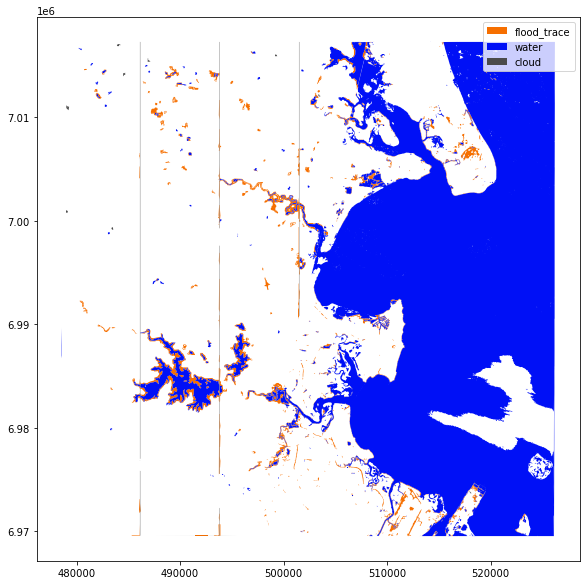

In [15]:
plot_utils.plot_floodmap(data_post_second_period)

### Compute the difference between pre and post flood observed water

In [16]:
prepost_map_second = postprocess.compute_flood_water(floodmap_post_data=data_post_second_period, best_pre_flood_data=data_pre)
prepost_map_second

,class,geometry
0,water-pre-flood,"POLYGON ((495480.000 6979530.000, 495510.000 6..."
1,water-pre-flood,"POLYGON ((485790.000 6982470.000, 485790.000 6..."
2,water-pre-flood,"POLYGON ((498750.000 6983190.000, 498990.000 6..."
3,water-pre-flood,"POLYGON ((498060.000 6983190.000, 498000.000 6..."
4,water-pre-flood,"POLYGON ((498780.000 6983250.000, 498690.000 6..."
...,...,...
3577,water-post-flood,"POLYGON ((524200.000 6977100.000, 524200.000 6..."
3578,water-post-flood,"POLYGON ((524310.000 6977200.000, 524360.000 6..."
3579,water-post-flood,"POLYGON ((524640.000 6976920.000, 524610.000 6..."
3580,water-post-flood,"POLYGON ((524120.000 6977000.000, 524150.000 6..."


<AxesSubplot:>

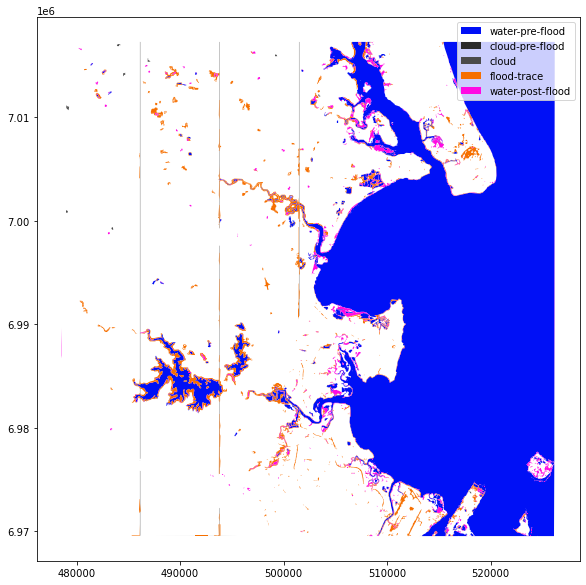

In [17]:
plot_utils.plot_floodmap(prepost_map_second)